# Problem Statement

The telecom industry is a highly competitive market with multiple service providers. The industry experiences an annual churn rate of ~15-20%.

Also, the customer acquisition cost is about 5-10 times more than the customer retention cost. So, **customer retention** is really important for the company.

The goal of this analysis is to build a model which can predict customers who are at high risk of churn.

### Basic Assumptions - 
We will assume that most customers do not decide to switch over to another competitor instantly, instead it happens over a period of time.

We can assume three stages of the customer lifecycle - 

1. **Good Phase** - Customer is happy with the service and behaves as usual.
2. **Action Phase** - The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc).
3. **Churn Phase** - The customer is said to have churned.

### Defining Churn

We will define the customers as churned if they have done no usage over a period of time (i.e. *Usage Based Churn*).

So, all the customers who have not made any incoming and outgoing calls and not utilised any internet for the last month (churn phase) will be tagged as churned.

We need to utilize all of the data in the preceding months (good phase and action phase) to predict which customers are at a high risk of getting churned.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

In [2]:
tele_data=pd.read_csv('telecom_churn_data.csv')
tele_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,...,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,...,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,2,6,362,252,252,0,252,252,252,0,6/21/2014,7/16/2014,08-08-14,9/28/2014,252,252,252,0,6/21/2014,7/16/2014,08-08-14,NaN,1.0,1.0,1.0,NaN,252.0,252.0,252.0,NaN,0.0,0.0,0.0,NaN,1.0,1.0,1.0,NaN,252.0,252.0,252.0,NaN,30.13,1.32,5.75,0.0,83.57,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.3

In [3]:
#check for duplicate mobile numbers.
print('Duplicates in the mobile_number feature are ',tele_data['mobile_number'].duplicated().sum())

Duplicates in the mobile_number feature are  0


In [4]:
print (tele_data.shape)
print (tele_data.info())
tele_data.describe()

(99999, 226)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
None


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,...,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,9

### Filtering the high value customers - 
In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers).

We will build the model for high-value customers, i.e. those who have recharged with an amount more than or equal to the 70th percentile of the average recharge amount in the first two months (the good phase).

In [5]:
#Checking if the rech amt for first 2 months has any null values.
print(tele_data['total_rech_amt_6'].isnull().sum())
print(tele_data['total_rech_amt_7'].isnull().sum())

0
0


In [6]:
#Finding the 70th percentile of the Avg. Recharge amount (first 2 months)
tele_data['total_avg_rech_amt(first 2 months)']=tele_data['total_rech_amt_6']+tele_data['total_rech_amt_7']/2
tele_data['total_avg_rech_amt(first 2 months)'].describe(percentiles=[0.2,0.4,0.5,0.7,0.9])

count    99999.000000
mean       488.996100
std        559.111306
min          0.000000
20%        143.500000
40%        267.000000
50%        343.000000
70%        554.000000
90%       1054.000000
max      55357.500000
Name: total_avg_rech_amt(first 2 months), dtype: float64

In [7]:
#Saving the 70th percentile
c=(tele_data['total_avg_rech_amt(first 2 months)'].describe(percentiles=[0.2,0.4,0.5,0.7,0.9])['70%'])

#Filtering the df by the 70th percentile - 
tele_data_hv=tele_data[tele_data['total_avg_rech_amt(first 2 months)']>c]
tele_data_hv.shape

(29961, 227)

So, we are left with 29961 high-value customers.

Now, we need to tag the people who have churned. The users who have not made any calls (ic and og) or have not utilized the internet even once in the latest month (October) will be tagged as churned.

In [8]:
#Checking for null values in the columns (required to check for churned customers)
print(tele_data_hv['total_og_mou_9'].isnull().sum())
print(tele_data_hv['total_ic_mou_9'].isnull().sum())
print(tele_data_hv['vol_2g_mb_9'].isnull().sum())
print(tele_data_hv['vol_3g_mb_9'].isnull().sum())

0
0
0
0


In [9]:
churned=((tele_data_hv['total_og_mou_9']==0) & (tele_data_hv['total_ic_mou_9']==0) & (
    tele_data_hv['vol_2g_mb_9']==0) & (tele_data_hv['vol_3g_mb_9']==0))

#Making a target column signifying churned customers

tele_data_hv['Churned_Customers']=0
tele_data_hv['Churned_Customers'][churned]=1
tele_data_hv['Churned_Customers'].sum()


2821

In [10]:
(2821/29961)*100

9.415573578986015

### Churn Rate
So, from the 29979 customers, 2821 have churned i.e. 9.42%.

This makes this case study and imbalance problem.

# Data Cleaning

Before proceeding with the missing value treatment we need to remove all the columns associated with the month of October (Since, this information will not be used for prediction).

The idea is that all of the attributes of the months before the churn phase (good and action phase) should tell us if a user is likely to churn or not.

In [11]:
#Identifying and storing all of the attributes of the last month and storing them in a list
col_remove=[i for i in list(tele_data_hv.columns) if '_9' in i]
tele_data_hv=tele_data_hv.drop(col_remove,axis='columns')
tele_data_hv.shape    

(29961, 174)

We are left with 174 features.

Let's take a look at the missing values in the df.

In [12]:
tele_data_hv.isnull().sum().sort_values(ascending=False)

av_rech_amt_data_7                    18580
fb_user_7                             18580
arpu_2g_7                             18580
arpu_3g_7                             18580
date_of_last_rech_data_7              18580
night_pck_user_7                      18580
total_rech_data_7                     18580
count_rech_3g_7                       18580
count_rech_2g_7                       18580
max_rech_data_7                       18580
av_rech_amt_data_6                    18355
count_rech_3g_6                       18355
total_rech_data_6                     18355
date_of_last_rech_data_6              18355
arpu_3g_6                             18355
count_rech_2g_6                       18355
arpu_2g_6                             18355
night_pck_user_6                      18355
max_rech_data_6                       18355
fb_user_6                             18355
total_rech_data_8                     18327
arpu_3g_8                             18327
av_rech_amt_data_8              

### Idea - 
There is a visible pattern here - When the 'date_of_last_rech_data_6' is NaN the rest of it's data related features are also NaN. 

This includes the features - ['total_rech_data_6', 'fb_user_6', 'av_rech_amt_data_6',
       'count_rech_2g_6', 'max_rech_data_6', 'arpu_3g_6', 'arpu_2g_6',
       'night_pck_user_6', 'date_of_last_rech_data_6', 'count_rech_3g_6']

The reason for a NaN in the date field is probably cause the user has not done any 'data-recharge' in that month.

So, with the exception of the date feature i.e. 'date_of_last_rech_data_' for each month we can replace the rest of the NaN values as 0 (signifying that no recharge done).

The above reasons hold true for each month i.e. 6,7 and 8 (June, July and August).

In [13]:
#Here we see that when the date is NaN all of the rest of the data associated attributes are also NaN
print("Month 6 \n",tele_data_hv[tele_data_hv['date_of_last_rech_data_6'].isnull()].isnull().sum(
).sort_values(ascending=False)[0:10])
print("\nMonth 7 \n",tele_data_hv[tele_data_hv['date_of_last_rech_data_7'].isnull()].isnull().sum(
).sort_values(ascending=False)[0:10])
print("\nMonth 8 \n",tele_data_hv[tele_data_hv['date_of_last_rech_data_8'].isnull()].isnull().sum(
).sort_values(ascending=False)[0:10])

Month 6 
 night_pck_user_6            18355
fb_user_6                   18355
count_rech_2g_6             18355
count_rech_3g_6             18355
av_rech_amt_data_6          18355
total_rech_data_6           18355
date_of_last_rech_data_6    18355
arpu_3g_6                   18355
arpu_2g_6                   18355
max_rech_data_6             18355
dtype: int64

Month 7 
 total_rech_data_7           18580
count_rech_3g_7             18580
arpu_3g_7                   18580
date_of_last_rech_data_7    18580
av_rech_amt_data_7          18580
night_pck_user_7            18580
fb_user_7                   18580
count_rech_2g_7             18580
max_rech_data_7             18580
arpu_2g_7                   18580
dtype: int64

Month 8 
 av_rech_amt_data_8          18327
arpu_2g_8                   18327
max_rech_data_8             18327
total_rech_data_8           18327
count_rech_2g_8             18327
fb_user_8                   18327
night_pck_user_8            18327
arpu_3g_8               

In [14]:
#As described above all the dates with NaNs have no recharges. So, we will instead replace NaN with 0 in 
#the required features.

c1=list(tele_data_hv[tele_data_hv['date_of_last_rech_data_6'].isnull()].isnull().sum(
).sort_values(ascending=False)[0:10].index)
c2=list(tele_data_hv[tele_data_hv['date_of_last_rech_data_7'].isnull()].isnull().sum(
).sort_values(ascending=False)[0:10].index)
c3=list(tele_data_hv[tele_data_hv['date_of_last_rech_data_8'].isnull()].isnull().sum(
).sort_values(ascending=False)[0:10].index)

c=c1+c2+c3

tele_data_hv[c]=tele_data_hv[c].fillna(0)

In [15]:
tele_data_hv.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_avg_rech_amt(first 2 months),Churned_Customers
6,7001051193,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,429.023,190.704,255.114,71.03,45.03,76.66,262.73,49.24,92.08,0.00,0.00,0.00,0.00,0.00,0.00,71.03,45.03,76.14,252.23,48.71,80.63,10.38,0.00,0.00,0.11,0.0,0.00,333.64,93.74,156.78,0.00,0.00,0.51,0.00,0.53,11.45,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.53,11.96,0.0,0.00,0.00,0.11,0.53,0.00,0.0,0.0,0.0,333.76,94.81,168.74,1857.99,1427.04,1896.43,248.64,336.96,265.28,20.24,22.69,2.51,2126.89,1786.71,2164.23,0.00,0.00,0.00,1.39,0.76,2.60,0.00,0.00,0.00,0.0,0.0,0.0,1.39,0.76,2.60,2128.41,1788.06,2167.11,0.00,0.0,0.0,0.00,0.00,0.00,0.11,0.58,0.28,15,10,11,499,222,294,90,37,50,6/28/2014,7/31/2014,8/28/2014,37,24,10,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1673,0.00,0.00,0.00,0.0,610.0,0
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.2

In [16]:
#Rechecking the null values
tele_data_hv.isnull().sum().sort_values(ascending=False)

roam_ic_mou_8                         1141
std_og_t2f_mou_8                      1141
loc_og_t2m_mou_8                      1141
loc_og_t2f_mou_8                      1141
loc_og_t2t_mou_8                      1141
std_og_t2c_mou_8                      1141
loc_ic_t2m_mou_8                      1141
roam_og_mou_8                         1141
ic_others_8                           1141
std_ic_t2f_mou_8                      1141
std_og_t2t_mou_8                      1141
std_og_mou_8                          1141
loc_og_t2c_mou_8                      1141
offnet_mou_8                          1141
isd_og_mou_8                          1141
loc_ic_t2t_mou_8                      1141
onnet_mou_8                           1141
std_ic_t2m_mou_8                      1141
spl_ic_mou_8                          1141
std_og_t2m_mou_8                      1141
std_ic_t2t_mou_8                      1141
spl_og_mou_8                          1141
loc_og_mou_8                          1141
loc_ic_mou_

### Missing minutes of usage

So, when the total_og and total_ic mou for each month is zero then their corresponding features will also be zero.

e.g- If total_og_mou is zero then isd_og_mou_8,std_og_mou_8,spl_og_mou_8 and loc_og_mou_8 will also be zero (same for ic mou).

Note - The roaming mou does not come under the total mou of the month (as seen below).

In [17]:
#For mou==0 the roaming mou is not zero.
tele_data_hv.loc[tele_data_hv['total_og_mou_8']==0,'roam_og_mou_8']

17        13.34
69         0.00
111         NaN
143         NaN
188         NaN
          ...  
99836      9.94
99855      0.00
99868    114.99
99997      0.00
99998       NaN
Name: roam_og_mou_8, Length: 2609, dtype: float64

# Roam og and ig is not zero even when total og and total ig is zero.

So, we cannot impute roam ig and og mou which are nan as 0 (based on our logic). However, all of the other mou for the month can be imputed as zero.

In [18]:
#Let's write a small function which does the missing value treatment.
#It basically checks for the ic and og calls with 0 mou and checks for the corresponding features for ic and og.
#It imputes the nan values for these features with zero.
def impute_nan(cols,k,df): 
    cols_og=[i for i in cols if ('mou_'+k in i) & ('og' in i)  | ('og_others_'+k in i)] #cols of og mou
    cols_ic=[i for i in cols if ('mou_'+k in i) & ('ic' in i)   | ('ic_others_'+k in i)] #cols of ic mou
    
    cols_mou=[i for i in cols if ('offnet_mou_'+k in i) | ('onnet_mou_'+k in i)] #all other cols
    #print(cols_mou)
    t_og=df['total_og_mou_'+k]==0
    t_ic=df['total_ic_mou_'+k]==0
    df.loc[t_og,cols_og]=df.loc[t_og,cols_og].fillna(0)
    df.loc[t_ic,cols_ic]=df.loc[t_ic,cols_ic].fillna(0)
    df.loc[(t_ic & t_og),cols_mou]=df.loc[(t_ic & t_og),cols_mou].fillna(0)
    return(df)

In [19]:
cols=list(tele_data_hv.columns)
tele_data_hv=impute_nan(cols,str(6),tele_data_hv)
tele_data_hv=impute_nan(cols,str(7),tele_data_hv)
tele_data_hv=impute_nan(cols,str(8),tele_data_hv)

In [20]:
#The last date of the month will not change (so we can impute the nan values there)
tele_data_hv['last_date_of_month_8']=tele_data_hv['last_date_of_month_8'].fillna(method='bfill')
tele_data_hv['last_date_of_month_7']=tele_data_hv['last_date_of_month_7'].fillna(method='bfill')

In [21]:
((tele_data_hv.isnull().sum().sort_values(ascending=False)/tele_data_hv.shape[0])*100).head(10)

date_of_last_rech_8    2.296319
date_of_last_rech_7    0.650846
loc_og_t2o_mou         0.417209
std_og_t2o_mou         0.417209
loc_ic_t2o_mou         0.417209
date_of_last_rech_6    0.083442
Churned_Customers      0.000000
spl_og_mou_6           0.000000
og_others_8            0.000000
og_others_7            0.000000
dtype: float64

The rest of the missing values represent less than 3 % of the total data. 

However, removing them will reduce a significant number of churned customers (which are important since it's an imbalance problem).

We can take a further look at the mou columns before deciding on a strategy to impute them.

In [22]:
#Checking for the count of mou's for each of the missing value columns
print(tele_data_hv['loc_og_t2o_mou'].value_counts())
print(tele_data_hv['std_og_t2o_mou'].value_counts())
print(tele_data_hv['loc_ic_t2o_mou'].value_counts())

0.0    29836
Name: loc_og_t2o_mou, dtype: int64
0.0    29836
Name: std_og_t2o_mou, dtype: int64
0.0    29836
Name: loc_ic_t2o_mou, dtype: int64


For all three of the above columns each observation has a value of 0. Keeping this in mind we can impute the NaNs in this column by 0.

Idea,

If for the null values of date_of_last_rech(for the month) the total_rech_num(for the month) is 0, it means that there was no recharge done on that month.

In this case we can simply impute the dates as 0 (which signify that no recharge was done on that month).

In [23]:
#Checking if a recharge has been done for the null values in 'date_of_last_rech' for each month
print(tele_data_hv[tele_data_hv['date_of_last_rech_6'].isnull()]['total_rech_num_6'].sum())
print(tele_data_hv[tele_data_hv['date_of_last_rech_7'].isnull()]['total_rech_num_7'].sum())
print(tele_data_hv[tele_data_hv['date_of_last_rech_8'].isnull()]['total_rech_num_8'].sum())

0
0
0


In [24]:
#Keeping the above things in mind we can impute all of the rest of the NaN values in the dataset by 0.
tele_data_hv=tele_data_hv.fillna(0)

In [25]:
tele_data_hv.shape

(29961, 174)

In [26]:
tele_data_hv.isnull().sum()

mobile_number                         0
circle_id                             0
loc_og_t2o_mou                        0
std_og_t2o_mou                        0
loc_ic_t2o_mou                        0
last_date_of_month_6                  0
last_date_of_month_7                  0
last_date_of_month_8                  0
arpu_6                                0
arpu_7                                0
arpu_8                                0
onnet_mou_6                           0
onnet_mou_7                           0
onnet_mou_8                           0
offnet_mou_6                          0
offnet_mou_7                          0
offnet_mou_8                          0
roam_ic_mou_6                         0
roam_ic_mou_7                         0
roam_ic_mou_8                         0
roam_og_mou_6                         0
roam_og_mou_7                         0
roam_og_mou_8                         0
loc_og_t2t_mou_6                      0
loc_og_t2t_mou_7                      0


In [27]:
#Number of total churned customers
tele_data_hv['Churned_Customers'].sum()

2821

In [28]:
#Reseting the index
tele_data_hv=tele_data_hv.reset_index(drop=True)

# EDA and Feature Engineering

First thing that we can do is modify the date columns in such a way that they can convey meaninful information to the model.

In [29]:
import datetime as dt
cols_date=[i for i in cols if 'date' in i]
cols_date

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [30]:
#Small function to extract the day from the different types of dates columns
def get_days(col):
    import re
    x=[0 if len(str(i))==1 else re.split(r'/|-',i[2:5]) for i in tele_data_hv[col]]
    date=[]
    for item in x:
        if type(item)==list:
            date.append([int(i) for i in item if i!=''])
        else:
            date.append([0])
        #date=[date[i][0] for i in range(0,len(date))] 
    return(date)

In [31]:
#replacing each of the date columns with the day
for i in cols_date:
    tele_data_hv[i]=[j for i in get_days(i) for j in i] #to get rid of nested lists inside
tele_data_hv[cols_date].head()

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,30,31,31,28,31,28,0,0,0
1,30,31,31,27,25,26,0,0,0
2,30,31,31,25,31,30,0,31,23
3,30,31,31,20,22,30,0,0,30
4,30,31,31,30,31,14,0,0,0


###### New attribute - days since last recharge.
This will tell us how long it has been since the customer has made a recharge/ a data recharge.

We can remove all of the other date columns after introducing these new columns (since they will no longer add value to the analysis).

In [32]:
#Making a new attribute (days since last recharge)
for i in ['6','7','8']:
    tele_data_hv['days_since_last_recharge_'+i]=tele_data_hv['last_date_of_month_'+i
                                                       ]-tele_data_hv['date_of_last_rech_'+i] #for recharge
    
    tele_data_hv['days_since_last_data_recharge_'+i]=tele_data_hv['last_date_of_month_'+i #for data recharge
                                                            ]-tele_data_hv['date_of_last_rech_data_'+i] 

In [33]:
#Since we have the days since last recharge we no longe need the actual dates
tele_data_hv=tele_data_hv.drop(cols_date,axis=1)
tele_data_hv.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_avg_rech_amt(first 2 months),Churned_Customers,days_since_last_recharge_6,days_since_last_data_recharge_6,days_since_last_recharge_7,days_since_last_data_recharge_7,days_since_last_recharge_8,days_since_last_data_recharge_8
0,7001051193,109,0.0,0.0,0.0,429.023,190.704,255.114,71.03,45.03,76.66,262.73,49.24,92.08,0.00,0.00,0.00,0.00,0.00,0.00,71.03,45.03,76.14,252.23,48.71,80.63,10.38,0.00,0.00,0.11,0.0,0.00,333.64,93.74,156.78,0.00,0.00,0.51,0.00,0.53,11.45,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.53,11.96,0.0,0.00,0.00,0.11,0.53,0.00,0.0,0.0,0.0,333.76,94.81,168.74,1857.99,1427.04,1896.43,248.64,336.96,265.28,20.24,22.69,2.51,2126.89,1786.71,2164.23,0.00,0.00,0.00,1.39,0.76,2.60,0.00,0.00,0.00,0.0,0.0,0.0,1.39,0.76,2.60,2128.41,1788.06,2167.11,0.00,0.0,0.0,0.00,0.00,0.00,0.11,0.58,0.28,15,10,11,499,222,294,90,37,50,37,24,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1673,0.00,0.00,0.00,0.0,610.0,0,2,30,0,31,3,31
1,7000701601,109,0.0,0.0,0.0,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.0,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.0,0.0,0.0,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.1

In [34]:
#Storing the cols as a list
cols=list(tele_data_hv.columns)
cols

['mobile_number',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6

##### Basic EDA

In [35]:
tele_data_hv.shape

(29961, 171)

In [36]:
tele_data.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,...,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_avg_rech_amt(first 2 months)
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

In [37]:
tele_data_hv.corr()['Churned_Customers'].sort_values()

total_ic_mou_8                       -0.206213
arpu_8                               -0.199572
total_rech_amt_8                     -0.198560
loc_ic_mou_8                         -0.197418
total_og_mou_8                       -0.192970
loc_og_mou_8                         -0.185655
loc_og_t2m_mou_8                     -0.185350
loc_ic_t2m_mou_8                     -0.184652
total_rech_num_8                     -0.170478
fb_user_8                            -0.167247
offnet_mou_8                         -0.159570
max_rech_amt_8                       -0.159028
last_day_rch_amt_8                   -0.140606
aon                                  -0.132371
loc_og_mou_7                         -0.129037
loc_og_t2m_mou_7                     -0.126941
max_rech_data_8                      -0.126494
loc_ic_mou_7                         -0.124854
av_rech_amt_data_8                   -0.120977
total_ic_mou_7                       -0.118444
loc_ic_t2m_mou_7                     -0.115523
loc_ic_t2t_mo

In [38]:
tele_data_hv['loc_og_t2o_mou'].value_counts()

0.0    29961
Name: loc_og_t2o_mou, dtype: int64

In [39]:
[i for i in cols if 'ic' in i and '6' in i]

['roam_ic_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_t2o_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6',
 'ic_others_6']

So,

- total_ic_mou_6=sum of 
(['loc_ic_mou_6','std_ic_mou_6','spl_ic_mou_6','isd_ic_mou_6','ic_others_6'])


- total_ic_mou_6= sum of (['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6'
 ,'std_ic_t2o_mou_6','std_ic_t2f_mou_6','ic_others_6','spl_ic_mou_6','isd_ic_mou_6'])

This holds true for all months.

It does not include the roaming ic.

Also, all of the loc and std mou features add up to the total loc and std mou respectively.

In [40]:
#Checking for the above  
((tele_data_hv[['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6'
                    ,'std_ic_t2o_mou_6','std_ic_t2f_mou_6','ic_others_6','spl_ic_mou_6','isd_ic_mou_6']
            ].sum(axis=1))-(tele_data_hv['total_ic_mou_6'])<0.05).sum()

29961

In [41]:
#Checking for the above 
((tele_data_hv[['loc_ic_mou_6','std_ic_mou_6','spl_ic_mou_6','isd_ic_mou_6','ic_others_6']
            ].sum(axis=1))-(tele_data_hv['total_ic_mou_6'])<0.05).sum()

29961

##### So, a lot of information is being repeated. There is a lot of multicollinearity in the df.

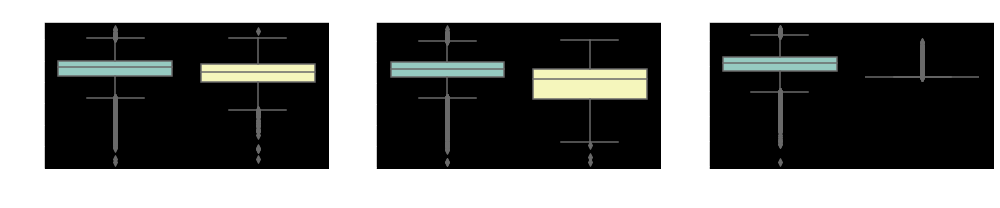

In [42]:
#Distribution of incoming mou for the three months
plt.figure(figsize=(14,3))

plt.subplot(1, 3, 1)
plt.title('Incoming mou for June')
sns.boxplot(y=np.log(tele_data_hv['total_ic_mou_6']),x=tele_data_hv['Churned_Customers'])

plt.subplot(1, 3, 2)
plt.title('Incoming mou for July')
sns.boxplot(y=np.log(tele_data_hv['total_ic_mou_7']),x=tele_data_hv['Churned_Customers'])

plt.subplot(1, 3, 3)
plt.title('Incoming mou for August')
sns.boxplot(y=np.log(tele_data_hv['total_ic_mou_8']),x=tele_data_hv['Churned_Customers'])

plt.tight_layout()
plt.show()

Idea,
Since the churn is based on usage we can actually make a few new features which can tell us if the mou(for both ic and og) have increased or decreased over time.

We can do this by taking an average over the first two months (good phase) and subtract the average with the third month.

So, the idea is that satisfied customers will have a similar or higher mou in the later months compared to not satisfied customers.

In [43]:
#Here a positive value means that the avg. of the first two months > value of the third month.
# So a value of 0 or -ve will be indicative of a higher 
tele_data_hv['change_in_ic_mou']=(
    ((tele_data_hv['total_ic_mou_6']+tele_data_hv['total_ic_mou_7'])/2)-tele_data_hv['total_ic_mou_8'])
tele_data_hv['change_in_og_mou']=(
    ((tele_data_hv['total_og_mou_6']+tele_data_hv['total_og_mou_7'])/2)-tele_data_hv['total_og_mou_8'])

In [44]:
tele_data_hv.corr()['Churned_Customers'].sort_values()

total_ic_mou_8                       -0.206213
arpu_8                               -0.199572
total_rech_amt_8                     -0.198560
loc_ic_mou_8                         -0.197418
total_og_mou_8                       -0.192970
loc_og_mou_8                         -0.185655
loc_og_t2m_mou_8                     -0.185350
loc_ic_t2m_mou_8                     -0.184652
total_rech_num_8                     -0.170478
fb_user_8                            -0.167247
offnet_mou_8                         -0.159570
max_rech_amt_8                       -0.159028
last_day_rch_amt_8                   -0.140606
aon                                  -0.132371
loc_og_mou_7                         -0.129037
loc_og_t2m_mou_7                     -0.126941
max_rech_data_8                      -0.126494
loc_ic_mou_7                         -0.124854
av_rech_amt_data_8                   -0.120977
total_ic_mou_7                       -0.118444
loc_ic_t2m_mou_7                     -0.115523
loc_ic_t2t_mo

We can see from above that the user created features (change_in_og_mou, days_since_last_recharge for all months,
and the change in incoming mou) show a relatively strong correlation to churned customers.

We can further create more features which signify usage.

However, the change in recharge amount may not be indicative of churn since prepaid customers (especially high end customers) tend to choose a recharge pack which lasts longer than a month (so they may not actually recharge in the coming months but this behaviour may not be indicative of churn).

Also, there are several features which do not show any particular correlation to churned customers (they do not show any variation across all the rows/observations). We can remove these rows from the analysis.

In [45]:
#Checking for the cols which show NaN in the correlation to Churned customers.
tele_data_hv[['std_ic_t2o_mou_8','std_ic_t2o_mou_7','std_ic_t2o_mou_6','std_og_t2c_mou_8','std_og_t2c_mou_7',
             'std_og_t2c_mou_6','loc_ic_t2o_mou','std_og_t2o_mou','loc_og_t2o_mou']].sum()

std_ic_t2o_mou_8    0.0
std_ic_t2o_mou_7    0.0
std_ic_t2o_mou_6    0.0
std_og_t2c_mou_8    0.0
std_og_t2c_mou_7    0.0
std_og_t2c_mou_6    0.0
loc_ic_t2o_mou      0.0
std_og_t2o_mou      0.0
loc_og_t2o_mou      0.0
dtype: float64

Since all of the above features add upto 0, i.e. there is no variation within these features we can remove them from the analysis.

Also, since the circle_id is the same for all observations it can also be removed.

In [46]:
tele_data_hv=tele_data_hv.drop(['std_ic_t2o_mou_8','std_ic_t2o_mou_7','std_ic_t2o_mou_6','std_og_t2c_mou_8','std_og_t2c_mou_7',
             'std_og_t2c_mou_6','loc_ic_t2o_mou','std_og_t2o_mou','loc_og_t2o_mou','circle_id'],axis=1)
tele_data_hv.shape

(29961, 163)

In [47]:
#Creating new features (based on the same principle as all of the other created features)

tele_data_hv['change_in_loc_ic_mou']=(
    ((tele_data_hv['loc_ic_mou_6']+tele_data_hv['loc_ic_mou_7'])/2)-tele_data_hv['loc_ic_mou_8'])

tele_data_hv['change_in_std_ic_mou']=(
    ((tele_data_hv['std_ic_mou_6']+tele_data_hv['std_ic_mou_7'])/2)-tele_data_hv['std_ic_mou_8'])

tele_data_hv['change_in_onnet_mou']=(
    ((tele_data_hv['onnet_mou_6']+tele_data_hv['onnet_mou_7'])/2)-tele_data_hv['onnet_mou_8'])

tele_data_hv['change_in_offnet_mou']=(
    ((tele_data_hv['offnet_mou_6']+tele_data_hv['offnet_mou_7'])/2)-tele_data_hv['offnet_mou_8'])

tele_data_hv['change_in_monthly2g']=(
    ((tele_data_hv['monthly_2g_6']+tele_data_hv['monthly_2g_7'])/2)-tele_data_hv['monthly_2g_8'])

tele_data_hv['change_in_sachet2g']=(
    ((tele_data_hv['sachet_2g_6']+tele_data_hv['sachet_2g_7'])/2)-tele_data_hv['sachet_2g_8'])

tele_data_hv['change_in_sachet3g']=(
    ((tele_data_hv['sachet_3g_6']+tele_data_hv['sachet_3g_7'])/2)-tele_data_hv['sachet_3g_8'])

tele_data_hv['change_in_vol3g']=(
    ((tele_data_hv['vol_3g_mb_6']+tele_data_hv['vol_3g_mb_7'])/2)-tele_data_hv['vol_3g_mb_8'])

tele_data_hv['change_in_vol2g']=(
    ((tele_data_hv['vol_2g_mb_6']+tele_data_hv['vol_2g_mb_7'])/2)-tele_data_hv['vol_2g_mb_8'])




In [48]:
tele_data_hv.corr()['Churned_Customers'].sort_values()

total_ic_mou_8                       -0.206213
arpu_8                               -0.199572
total_rech_amt_8                     -0.198560
loc_ic_mou_8                         -0.197418
total_og_mou_8                       -0.192970
loc_og_mou_8                         -0.185655
loc_og_t2m_mou_8                     -0.185350
loc_ic_t2m_mou_8                     -0.184652
total_rech_num_8                     -0.170478
fb_user_8                            -0.167247
offnet_mou_8                         -0.159570
max_rech_amt_8                       -0.159028
last_day_rch_amt_8                   -0.140606
aon                                  -0.132371
loc_og_mou_7                         -0.129037
loc_og_t2m_mou_7                     -0.126941
max_rech_data_8                      -0.126494
loc_ic_mou_7                         -0.124854
av_rech_amt_data_8                   -0.120977
total_ic_mou_7                       -0.118444
loc_ic_t2m_mou_7                     -0.115523
loc_ic_t2t_mo

Taking a look at the top 15 most positive and negatively correlated features with the Churned Customers.

In [49]:
cols_heatmap=abs(tele_data_hv.corr()['Churned_Customers']).sort_values()[0:15].index

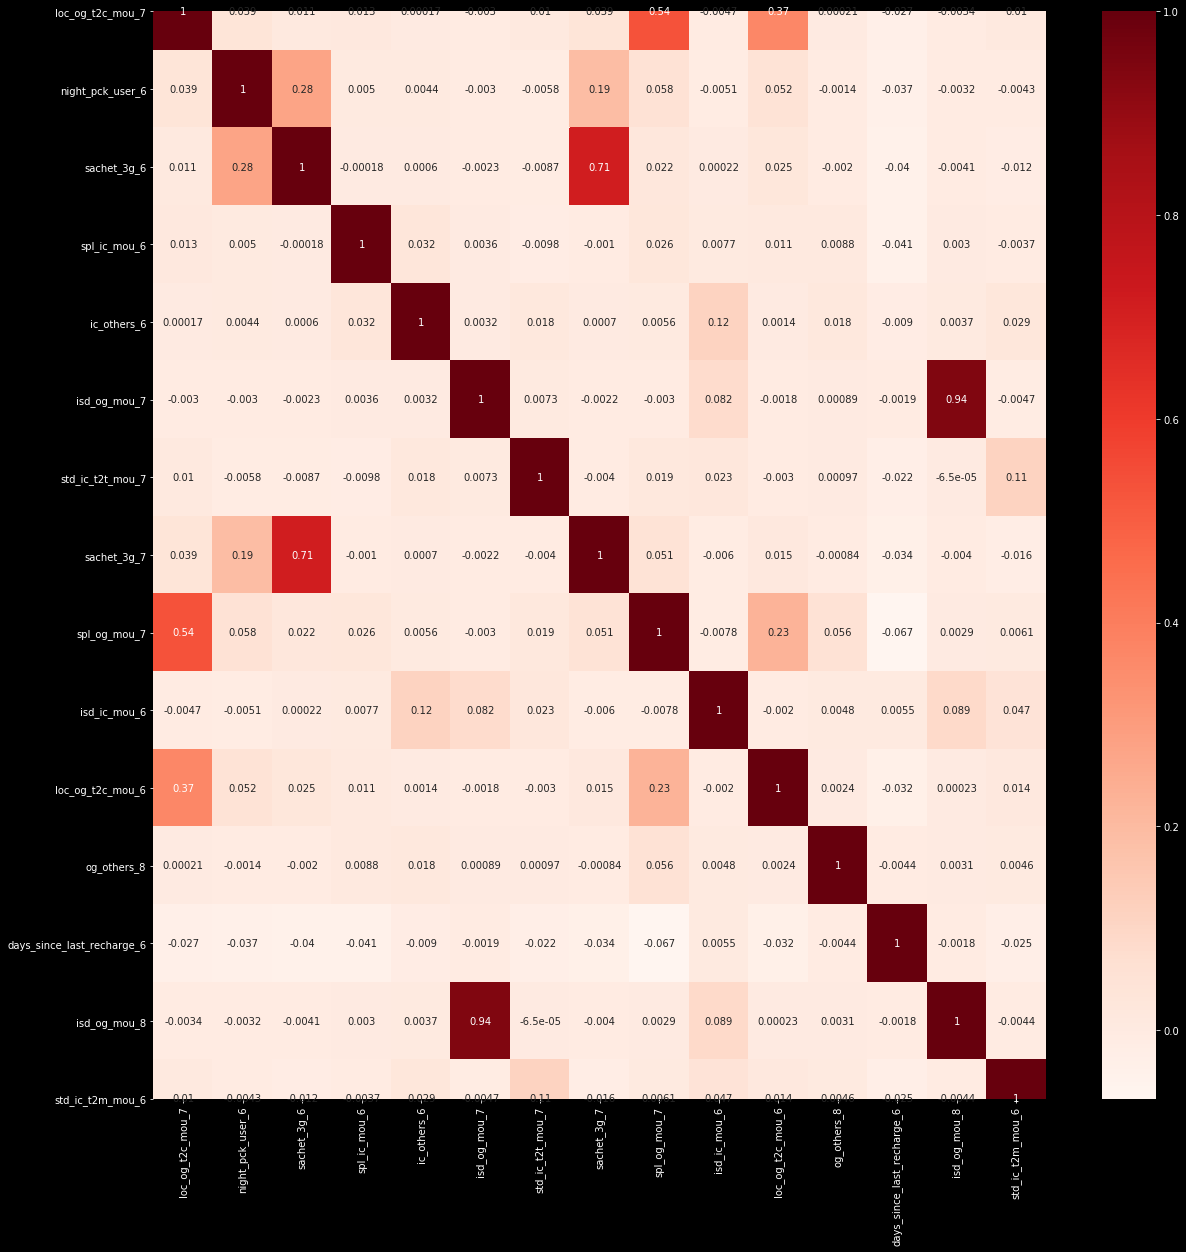

In [50]:
plt.style.use('dark_background')
plt.figure(figsize=(20,20))
sns.heatmap(tele_data_hv[cols_heatmap].corr(),annot=True,cmap='Reds')
plt.show()

We can see from the above plot that there is plenty of multicollinearity in the dataset. This stems from the fact that there are multiple features which are related to each other.

eg- total_ic_mou_8 shows high correlation with loc_ic_mou_8. 
change in ic mou is highly correlated to change in loc ic mou. There are many more instances of this and they need to be kept in mind while building a model.

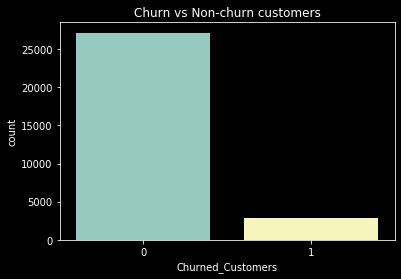

0    27140
1     2821
Name: Churned_Customers, dtype: int64

In [51]:
sns.countplot(tele_data_hv['Churned_Customers'])
plt.title('Churn vs Non-churn customers')
plt.show()
tele_data_hv['Churned_Customers'].value_counts()

Let's take a look at the distribution of values for a few of the features which show high correlation (positive and negative) to churned customers.

No handles with labels found to put in legend.


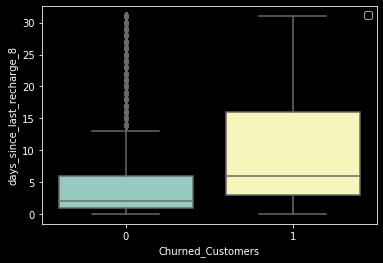

In [52]:
#Boxplots showing how the values of the features differ for churn and non-churn customers - 
plt.style.use('dark_background')
sns.boxplot(y=tele_data_hv['days_since_last_recharge_8'],x=tele_data_hv['Churned_Customers'])
plt.legend()
plt.show()

No handles with labels found to put in legend.


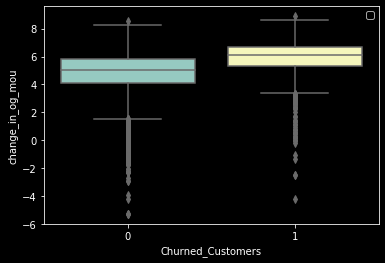

In [53]:
sns.boxplot(y=np.log(tele_data_hv['change_in_og_mou']),x=tele_data_hv['Churned_Customers'])
plt.legend()
plt.show()

No handles with labels found to put in legend.


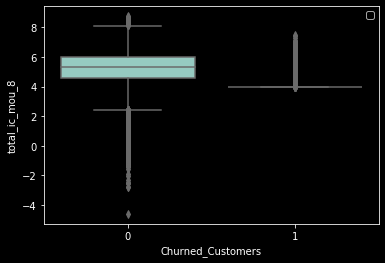

In [54]:
sns.boxplot(y=np.log(tele_data_hv['total_ic_mou_8']),x=tele_data_hv['Churned_Customers'])
plt.legend()
plt.show()

No handles with labels found to put in legend.


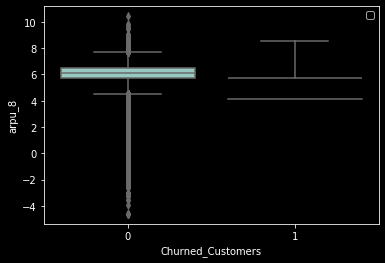

In [55]:
sns.boxplot(y=np.log(tele_data_hv['arpu_8']),x=tele_data_hv['Churned_Customers'])
plt.legend()
plt.show()

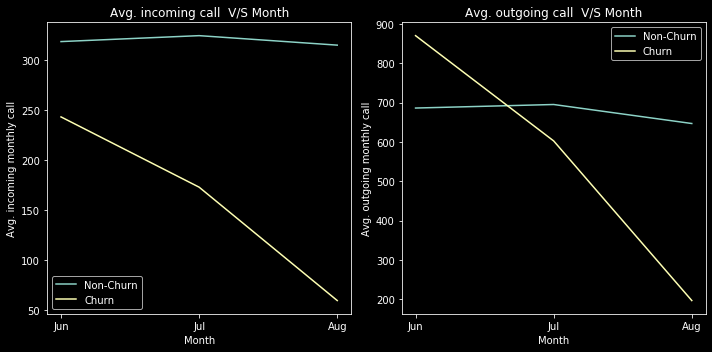

In [56]:
plt.figure(figsize=(10,5))

ax1=plt.subplot(1, 2, 1)
plt.title("Avg. incoming call  V/S Month")
plt.plot(
    tele_data_hv.groupby('Churned_Customers')['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8'].mean().T)
ax1.set_xticklabels(['Jun','Jul','Aug'])
plt.legend(['Non-Churn', 'Churn'])
plt.xlabel("Month")
plt.ylabel("Avg. incoming monthly call")

ax2=plt.subplot(1, 2, 2)
plt.title("Avg. outgoing call  V/S Month")
plt.plot(
    tele_data_hv.groupby('Churned_Customers')['total_og_mou_6','total_og_mou_7','total_og_mou_8'].mean().T)
ax2.set_xticklabels(['Jun','Jul','Aug'])
plt.legend(['Non-Churn', 'Churn'])
plt.xlabel("Month")
plt.ylabel("Avg. outgoing monthly call")

plt.tight_layout()
plt.show()

So, we can clearly see that the avg.mou for both incoming and outgoing calls is much lesser for churned customers (and continues to decrease each month).

# Modelling

There is a huge imbalance in the data, only 2821 customers have churned from the original 29979 (which means that only ~9.42% of the customers have churned). We need to keep this in mind while modelling.

We can first construct model to predict churned customers. 

The  objective here is to maximize the predicive power of the model (there is no need to make the model easy to interpret as long as it does a good enough job of prediction).

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#The mobile no. is a unique id for each customer hence it does not add value to the analysis. 
predictors=tele_data_hv.drop(['mobile_number','Churned_Customers'],axis=1)
target=tele_data_hv['Churned_Customers']

#Added a stratify in the train test split (which ensures that the division of labels is proportional in both sets)
x_train,x_test,y_train,y_test=train_test_split(predictors,target,stratify=target,train_size=0.8)
cols=list(predictors.columns)

In [58]:
#Proportion of churned customers is equal in train and test.
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.905833
1    0.094167
Name: Churned_Customers, dtype: float64
0    0.90589
1    0.09411
Name: Churned_Customers, dtype: float64


# Deciding a scoring metric

Here identifying churn is more important than identifying the non-churn customers.

So, it makes sense to give more weightage to recall(or sensitivity) i.e (tp/(tp+fn)).

# Model which maximizes predictive power.

Since the above model is relatively simple and utilizes only a few features we lose out a lot of information.

In order to maximize the predicitve power of the model we can perform PCA for feature selection and then use a predicitve learning algorithm (like an ensembl method) to maximize recall.

Using PCA will allow us to perform dimensionality reduction while at the same time retaining max possible information.

In [59]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

In [60]:
#Performing feature scaling on the data - 
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
#Scaling the features of the dataset
predictors_scaled=pd.DataFrame(scaler.fit_transform(predictors))
predictors_scaled.columns=predictors.columns

In [61]:
#Importing PCA, instantiating PCA and performing PCA for scaled data.
from sklearn.decomposition import PCA
pca=PCA(svd_solver='randomized', random_state=100)
pca.fit(predictors_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='randomized', tol=0.0, whiten=False)

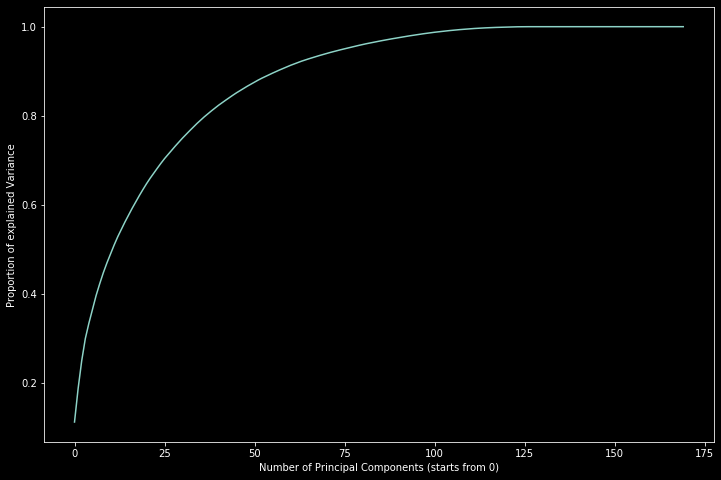

In [62]:
#Determining the final number of PC's for our data
plt.figure(figsize=(12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components (starts from 0)')
plt.ylabel('Proportion of explained Variance')
plt.savefig("Proportion of variance explained by the PC's.png",bbox_inches='tight')
plt.show()

From the above plot we can see that the first 75 PC's can explain more than 95% of the observed variance in the data.

(Note - In the above plot the numbering of PC's start from 0). 

In [63]:
#So let's perform PCA again (considering the first 75 PC's)
from sklearn.decomposition import IncrementalPCA
pca2=IncrementalPCA(n_components=75)

In [64]:
predictors_scaled.shape

(29961, 170)

In [65]:
#Transforming the original dataframe using PCA 
df_pca=pca2.fit_transform(predictors_scaled)
df_pca.shape

(29961, 75)

In [66]:
x_train,x_test,y_train,y_test=train_test_split(df_pca,target,stratify=target,train_size=0.8)

# Trying out different models and choosing the best one.

In [67]:
def clf(classifier,x_train,y_train,x_test,y_test):
    from sklearn.metrics import recall_score
    clf=classifier
    clf.fit(x_train,y_train)
    p=clf.predict(x_test)
    print(recall_score(y_test,p))

In [68]:
#RandomForest Base model recall score
clf(RandomForestClassifier(random_state=43),x_train,y_train,x_test,y_test)

0.18971631205673758


In [69]:
#DecisionTree Base model recall score
clf(DecisionTreeClassifier(random_state=43),x_train,y_train,x_test,y_test)

0.4432624113475177


In [70]:
#AdaBoost Base model recall score
shallow_tree = DecisionTreeClassifier(max_depth=2, random_state = 100)
clf(AdaBoostClassifier(base_estimator=shallow_tree),x_train,y_train,x_test,y_test)

0.41843971631205673


In [71]:
#XGBoost Base model recall score
clf(XGBClassifier(random_state=100),x_train,y_train,x_test,y_test)

0.38475177304964536


It's difficult to choose a classifier from the above results. However, this being an imbalance problem we can go for a boosting technique which by it's nature takes care of the data imbalance.

We will look at the XGBoost classifier, we will perform hyperparameter tuning for this classifier.

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

xgb=XGBClassifier(random_state=100)
#Instantiating a stratified kfold for the data (to ensure that the class distribution remains the same in train and test ) 

skf= StratifiedKFold()
skf = StratifiedKFold(n_splits=5)
param_grid = {
    'learning_rate':[0.2,0.5,0.9],
    'n_estimators': range(100,300,100) 
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = skf, scoring='recall')

In [73]:
%%time
grid_search.fit(x_train,y_train)

Wall time: 19min 37s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=100, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.2, 0.5, 0.

In [74]:
print('We can get recall of',grid_search.best_score_,'using',grid_search.best_params_)

We can get recall of 0.45059626784230516 using {'learning_rate': 0.9, 'n_estimators': 100}


In [75]:
#Using the chosen hyperparameters make predictions from the test set
xgb=XGBClassifier(learning_rate=grid_search.best_params_['learning_rate']
                 ,n_estimators=grid_search.best_params_['n_estimators'],random_state=100)
xgb.fit(x_train,y_train)
p=xgb.predict(x_test)
print(classification_report(p,y_test))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      5566
           1       0.45      0.60      0.51       427

    accuracy                           0.92      5993
   macro avg       0.71      0.77      0.74      5993
weighted avg       0.93      0.92      0.92      5993



Despite having an accuracy of above 90% we have a low recall score on the test set.

In order to improve this we can manually select a cutoff to make the prediciton (same thing we did for logistic regression).

In [76]:
xgb=XGBClassifier(learning_rate=grid_search.best_params_['learning_rate']
                 ,n_estimators=grid_search.best_params_['n_estimators'],random_state=100)
xgb.fit(x_train,y_train)
conv_prob=pd.DataFrame(xgb.predict_proba(x_train))[1] #Will give us the prob of churn

In [77]:
import sklearn.metrics as metrics
#Function to draw the actual ROC curve for visualization
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(9, 7))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

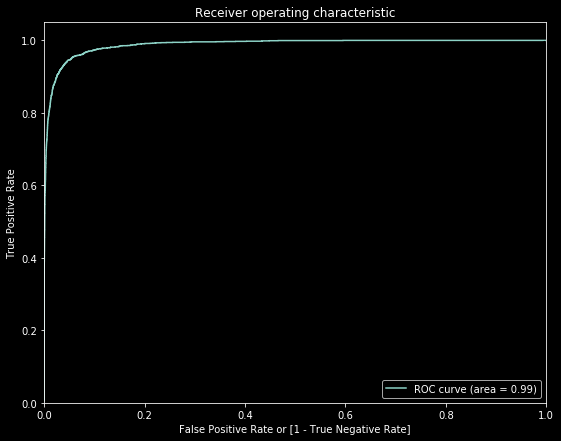

In [78]:
fpr, tpr, thresholds = metrics.roc_curve(y_train,conv_prob, drop_intermediate = False)
draw_roc(y_train,conv_prob)

In [79]:
#Defining a function which will help us in selecting the cutoff probability
def select_cutoff(converted,predicted_prob):
    #Creating a new dataframe to store the actual conversions and the predicted probabilities of conversion
    y_train_pred_final=pd.DataFrame({'Converted':converted.reset_index(drop=True),'Conv_Prob':predicted_prob})
    #Creating different columns for different cutoffs
    cutoffs=[float(x)/100 for x in range(100)]
    #Write a loop where if the prob is greater than the cutoff then consider the customer as converted
    for i in cutoffs:
        y_train_pred_final['Predicted_cutoff '+str(i)]=y_train_pred_final['Conv_Prob'].map(lambda x: 1 if x>i else 0)
    #Now we will see how good the predictions are for the respective cutoffs
    #Building a new df with accuracy,sensitivity and specificity as columns for each cutoff value
    cutoff_df=pd.DataFrame(columns=['prob','accuracy','sensitivity','specificity'])
    from sklearn.metrics import confusion_matrix
    cols=y_train_pred_final.columns[2:]
    for i in cols:
        cm1 = confusion_matrix(y_train_pred_final['Converted'], y_train_pred_final[i])
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
    
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[i,accuracy,sensi,speci]
    cutoff_df['prob']=cutoffs
    cutoff_df=cutoff_df.reset_index(drop=True)
    return cutoff_df

In [80]:
cutoff_df=select_cutoff(y_train,conv_prob)
cutoff_df

,prob,accuracy,sensitivity,specificity
0,0.00,0.094167,1.000000,0.000000
1,0.01,0.700225,0.996012,0.669476
2,0.02,0.785673,0.993797,0.764037
3,0.03,0.827979,0.989809,0.811156
4,0.04,0.852679,0.985379,0.838884
5,0.05,0.871078,0.981391,0.859610
6,0.06,0.885806,0.978733,0.876146
7,0.07,0.896404,0.976961,0.888029
8,0.08,0.905874,0.973859,0.898807
9,0.09,0.913510,0.970758,0.907558


In [81]:
conv_prob

0        0.004833
1        0.000005
2        0.958952
3        0.010069
4        0.014337
           ...   
23963    0.018130
23964    0.087420
23965    0.013655
23966    0.001107
23967    0.004346
Name: 1, Length: 23968, dtype: float32

In [82]:
#Storing the prediction prob and the actual prediciton in a dataframe. 
y_train_pred_final=pd.DataFrame({'Converted':y_train.reset_index(drop=True),'Conv_Prob':conv_prob})

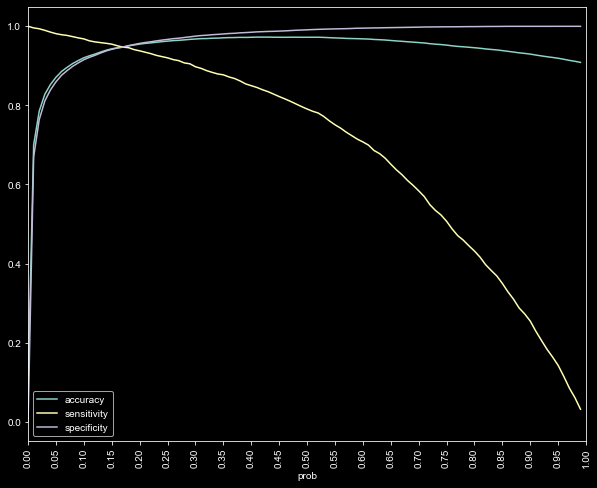

In [83]:
from matplotlib.pyplot import xticks
# Plotting accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'],figsize=(10,8))
plt.xticks(np.arange(min(cutoff_df['prob']), max(cutoff_df['prob']+0.04),0.05))
sns.set(font_scale=1)
xticks(rotation=90)
plt.show()

A probability of 0.12 seems ideal. Since the accuracy, sensitivity and specificity are relatively high (all above 90%) at this cutoff.

In [84]:
#Predicting on the training df using our chosen cutoff value
y_train_pred_final['Final Predictions']=y_train_pred_final['Conv_Prob'].map(lambda x:1 if x>0.10 else 0)
y_train_pred_final.head()

,Converted,Conv_Prob,Final Predictions
0,0,0.004833,0
1,0,0.000005,0
2,1,0.958952,1
3,0,0.010069,0
4,0,0.014337,0


In [85]:
print(classification_report(y_train_pred_final['Converted'],y_train_pred_final['Final Predictions']))

              precision    recall  f1-score   support

           0       1.00      0.92      0.95     21711
           1       0.54      0.97      0.70      2257

    accuracy                           0.92     23968
   macro avg       0.77      0.94      0.83     23968
weighted avg       0.95      0.92      0.93     23968



In [86]:
#Predicting the probabilities for the test set using the above model
from sklearn.metrics import accuracy_score
y_test_pred=(pd.DataFrame(xgb.predict_proba(x_test))[1]).map(lambda x:1 if x>0.10 else 0)
print(classification_report(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      5429
           1       0.42      0.76      0.54       564

    accuracy                           0.88      5993
   macro avg       0.70      0.82      0.74      5993
weighted avg       0.92      0.88      0.89      5993

0.8798598364758885


The above model works really well giving us a high recall score of as well as a high accuracy on the test set (above ~80%).

# Identifying the important features which can be used to predict churn.

In [87]:
#The mobile no. is a unique id for each customer hence it does not add value to the analysis. 
predictors=tele_data_hv.drop(['mobile_number','Churned_Customers'],axis=1)
target=tele_data_hv['Churned_Customers']

Since the entire point of building this second model is just to identify the variables which are strong predictors of churn (while not actually doing the prediction) we can use the entirety of the data available to us.

So, we don't need to split the data into training and testing sets.

In [88]:
#Using a decision tree to vizualize the most important features
from sklearn.tree import DecisionTreeClassifier

#We will set the default depth of the decision tree to 3 otherwise there might be too many features to vizualize.
dt= DecisionTreeClassifier(max_depth=3)
dt.fit(predictors, target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [89]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

# Putting features
features = list(predictors.columns[0:])

D:\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


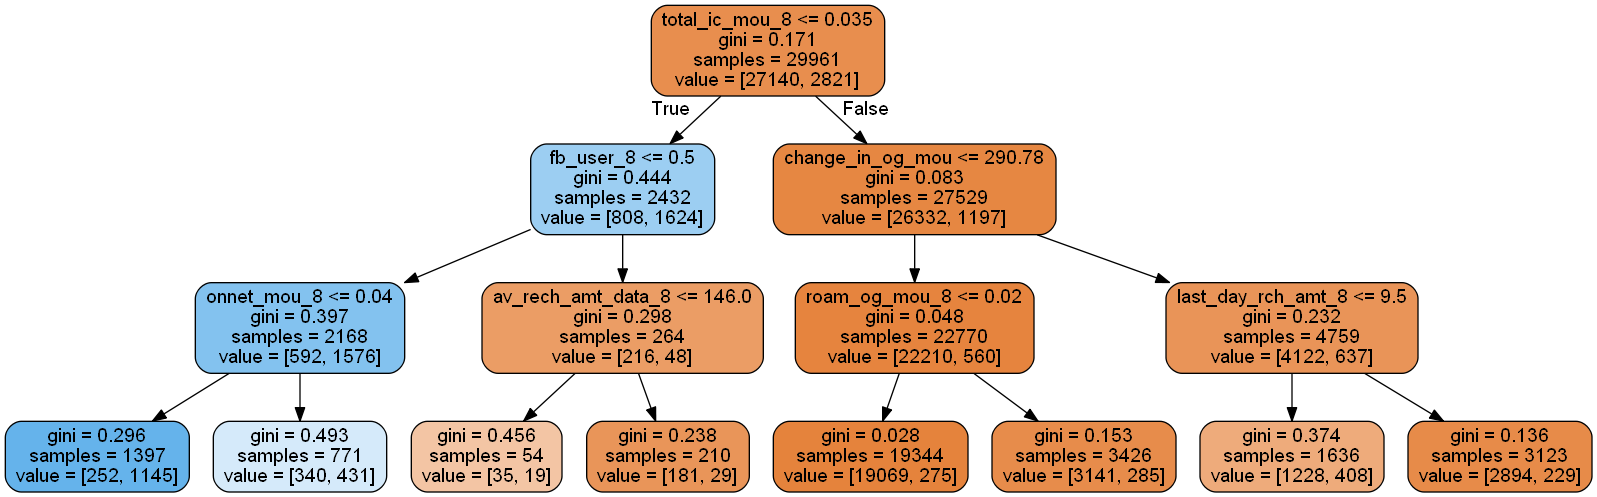

In [90]:
# Specifing path for dot file (req for windows)
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin/'

# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

We have identified multiple important features which affect churn in customers.

We can see how the value of the features changes for the churn and the non-churn customers.

In [91]:
def plot_box(col,c=1):
    plt.subplot(1,2,1)
    if c==1:
        sns.boxplot(y=np.log(tele_data_hv[col]),x=tele_data_hv['Churned_Customers'])
        plt.legend(labels=['Non_churn - 0','Churn - 1'])
    else:    
        sns.boxplot(y=tele_data_hv[col],x=tele_data_hv['Churned_Customers'])
        plt.legend(labels=['Non_churn - 0','Churn - 1'])

We have identified 7 features in total which are strong predictors in identfying customer churn.

We will look at the distribution of these features in churned and non-churned customers to see how their distributions vary for the two.

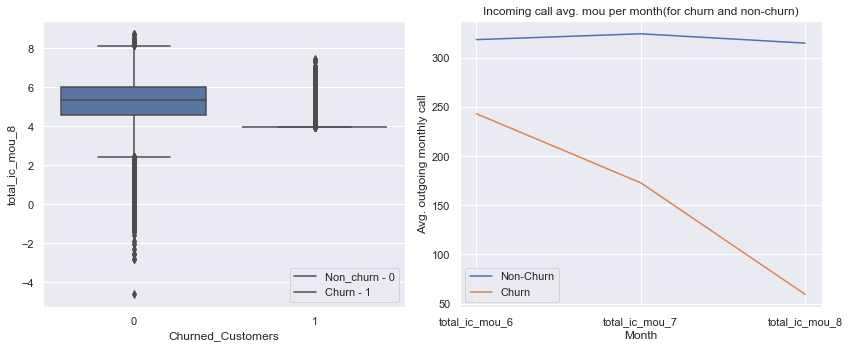

In [92]:
plt.figure(figsize=(12,5))
plot_box('total_ic_mou_8')
plt.subplot(1,2,2)
plt.title("Incoming call avg. mou per month(for churn and non-churn)")
plt.plot(
    tele_data_hv.groupby('Churned_Customers')['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8'].mean().T)
ax2.set_xticklabels(['Jun','Jul','Aug'])
plt.legend(['Non-Churn', 'Churn'])
plt.xlabel("Month")
plt.ylabel("Avg. outgoing monthly call")
plt.tight_layout()
plt.show()


So, there is an obvious difference in the values of incoming mou for the month of september for churn and non-churn customers.

Non-churn customers have had more minutes of usage (mou) then churned customers. 

Also, we can see that the avg. value for the total incoming mou decrease each month for the churned customers.


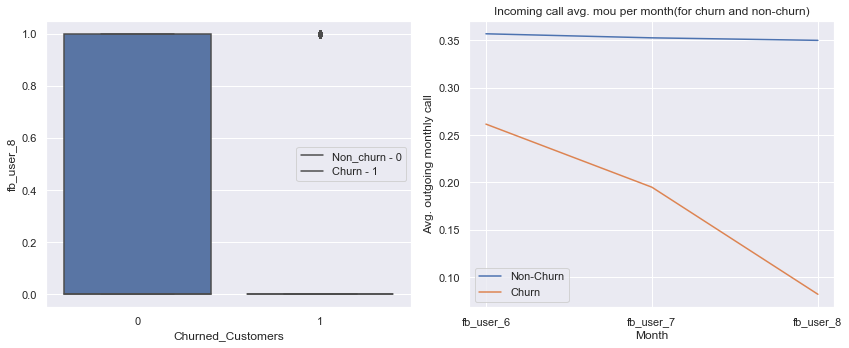

In [93]:
plt.figure(figsize=(12,5))
plot_box('fb_user_8',c=0)
plt.subplot(1,2,2)
plt.title("Incoming call avg. mou per month(for churn and non-churn)")
plt.plot(
    tele_data_hv.groupby('Churned_Customers')['fb_user_6','fb_user_7','fb_user_8'].mean().T)
plt.legend(['Non-Churn', 'Churn'])
plt.xlabel("Month")
plt.ylabel("Avg. outgoing monthly call")
plt.tight_layout()
plt.show()


We can see the same pattern as above for the fb_user per month.

This feature represents a Service scheme to avail services of Facebook and similar social networking sites. We see that it decreases in value for churned cutomers each month.

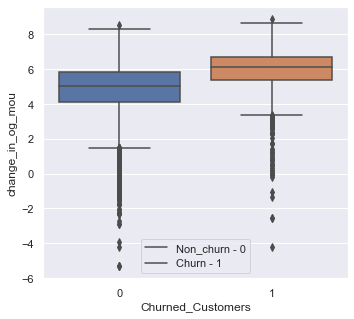

In [94]:
plt.figure(figsize=(12,5))
plot_box('change_in_og_mou')

The 'change in og mou' is a user created feature which describes how much the outgoing mou have changed in the three months.

change_in_og_mou= ((total_ic_mou_6 + total_ic_mou_7)/2)-total_ic_mou_8

So, if this value is positive it means that the customer has lesser mou for the month of September.

We can see that the value for this feature is higher for churned customers signifying that they have lesser mou for the month of September.

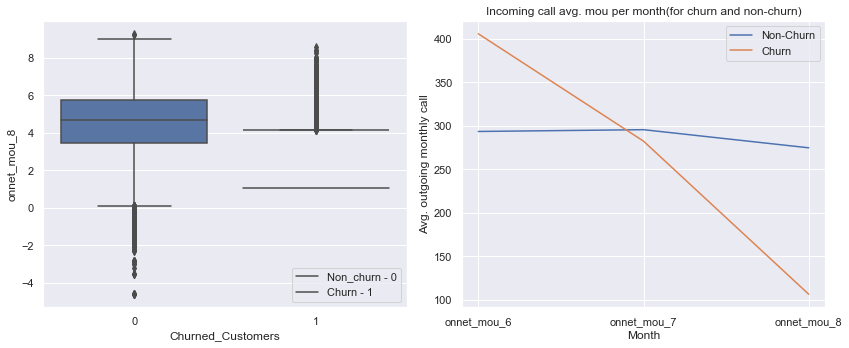

In [95]:
plt.figure(figsize=(12,5))
plot_box('onnet_mou_8')
plt.subplot(1,2,2)
plt.title("Incoming call avg. mou per month(for churn and non-churn)")
plt.plot(
    tele_data_hv.groupby('Churned_Customers')['onnet_mou_6','onnet_mou_7','onnet_mou_8'].mean().T)
plt.legend(['Non-Churn', 'Churn'])
plt.xlabel("Month")
plt.ylabel("Avg. outgoing monthly call")
plt.tight_layout()
plt.show()


As expected there is a sharp drop in the onnet mou for churned customers across the three months.

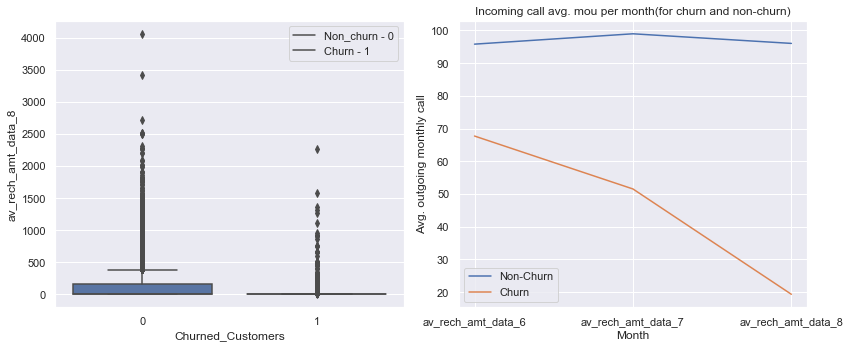

In [96]:
plt.figure(figsize=(12,5))
plot_box('av_rech_amt_data_8',c=0)
plt.subplot(1,2,2)
plt.title("Incoming call avg. mou per month(for churn and non-churn)")
plt.plot(
    tele_data_hv.groupby('Churned_Customers')['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8'].mean().T)
plt.legend(['Non-Churn', 'Churn'])
plt.xlabel("Month")
plt.ylabel("Avg. outgoing monthly call")
plt.tight_layout()
plt.show()

So, churned customers have a lesser value of data rech for the month of Sept and as usual we see that the avg. value of the data recharge is decreasing across the month for the churned customers.

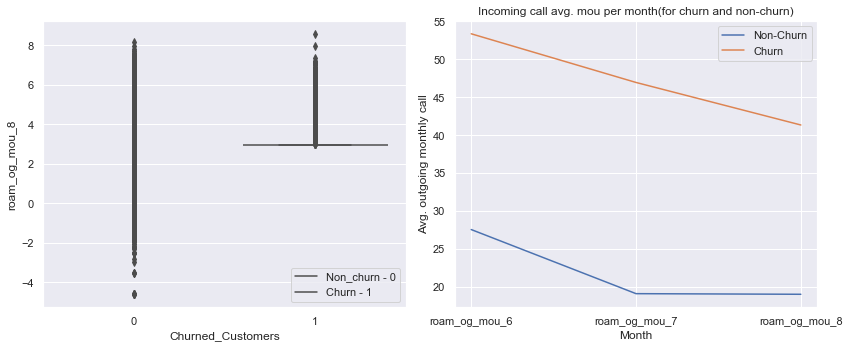

In [97]:
plt.figure(figsize=(12,5))
plot_box('roam_og_mou_8')
plt.subplot(1,2,2)
plt.title("Incoming call avg. mou per month(for churn and non-churn)")
plt.plot(
    tele_data_hv.groupby('Churned_Customers')['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8'].mean().T)
plt.legend(['Non-Churn', 'Churn'])
plt.xlabel("Month")
plt.ylabel("Avg. outgoing monthly call")
plt.tight_layout()
plt.show()

Suprisingly, the value of og_roam mou is higher for the churned customers even though we see that the value is gradually decreasing across the three months.

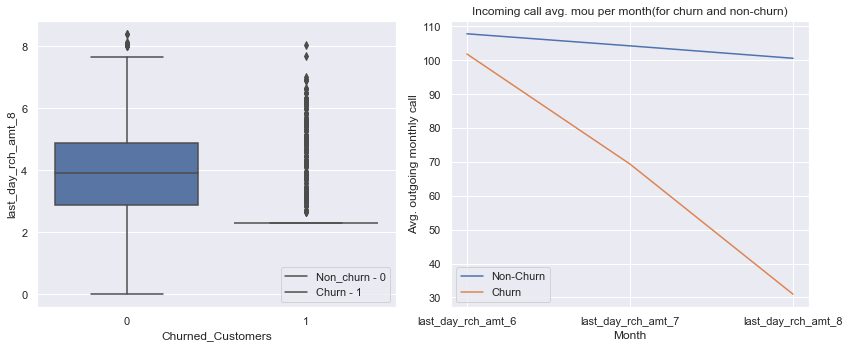

In [98]:
plt.figure(figsize=(12,5))
plot_box('last_day_rch_amt_8')
plt.subplot(1,2,2)
plt.title("Incoming call avg. mou per month(for churn and non-churn)")
plt.plot(
    tele_data_hv.groupby('Churned_Customers')['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8'].mean().T)
plt.legend(['Non-Churn', 'Churn'])
plt.xlabel("Month")
plt.ylabel("Avg. outgoing monthly call")
plt.tight_layout()
plt.show()

Like most other features the value of the last day rch amt for the month of September is much lower on avg for churned customers.

Also like before we see a sharp decrease for this value for churned customers across the three months.

# Strategies to manage customer churn

We already see a clear pattern where the customers who are about to churn have a gradual decrease in the features which signify usage like -

'total_ic_mou_8','fb_user_8','onnet_mou_8','change_in_mou','last_day_rch_amt_8', etc.

We can track these features across the months and check for which customers the value of these features are gradually decreasing.

#### Ways to reduce Churn - 

- For customers whose 'total_ic_mou','onnet_mou','av_rech_amt_data' and other usage related features have seen a gradual decrease across three months, we can say that they are likely to churn and roll out enticing offers which bring them back to the current network.
- After identifying the customers who are more likely to churn we can contact them and ask if they are having any issues with the network and fix the said issues.
- We can give the customers who are likely to churn personalized offers. E.g- Cutomers who have a history of using data packs can be given offers specific to data packs, and the ones using the network for calling can be given offers like better calling rates.

# Conclusion

For predicitng churn we used PCA followed by an XGBoost model which gave us a really good overall accuracy and recall score. This ensures that we can correctly identify the churned customers without too many false positives. 

However, this model while good at predicitng the churn will not enable us to identify the features which are indicatu=ive of churn.

So, we built a simple Decision Tree model to help us identify features which are strong predictors of churn. This model was utilized because it can be visualized and is easily interpretable by laymen.